The Parameters


In [3]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from math import *
import scipy.stats

def N(x):
    return scipy.stats.norm.cdf(x)

def compute_d1_and_d2( S, t, K, T, r, sigma):
    tau = T-t
    d1 = 1/(sigma*np.sqrt(tau))*(np.log(S/K) + (r+0.5*sigma**2)*tau)
    d2 = d1 - sigma*np.sqrt(tau)
    return d1,d2

def black_scholes_call_price(S, t, K, T, r, sigma):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,sigma)
    return S*N(d1) - np.exp(-r*(T-t))*K*N(d2)

def black_scholes_delta(S,t,K,T,r,sigma):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,sigma)
    return N(d1)

S0 = 130
K = 167
T = 1.5
gamma = 0.98
r = 0.03
t = 0
n_steps = 100

The volatility functions


In [4]:
def sigma_t(T, n_steps):
    sigma_t = np.zeros(n_steps+1)
    dt = T / n_steps
    t = np.linspace(0, T, n_steps+1)
    for i in range(n_steps+1):
        if t[i] < 0.3:
            sigma_t[i] = 0.12 + 0.09 * (t[i] / 0.3)
        else:
            sigma_t[i] = 0.21
    return sigma_t

def sigma_constant(T,n_steps):
    x = 0.21
    sigma_constant = np.zeros(n_steps+1)
    dt = T / n_steps
    t = np.linspace(0,T,n_steps+1)
    for i in range(n_steps+1):
        sigma_constant[i] = x
    return sigma_constant

sigma = sigma_constant(T,n_steps)[0]

bs_delta = black_scholes_delta(S0,t,K,T,r,sigma)
bs_price = black_scholes_call_price(S0,t,K,T,r,sigma)

In [5]:
def bottom_boundary_condition( K, T, S_min, r, t):
    return np.zeros(t.shape)

def top_boundary_condition( K, T, S_max, r, t):
    return S_max-np.exp(-r*(T-t))*K

def final_boundary_condition( K, T, S ):
    return np.maximum(S-K,0)

def compute_abc_with_time_varying_volatility(K, T, gamma, r, S, dt, dS, t_idx, N, sigma_func):
    t = np.linspace(0, T, N+1)
    sigmat = sigma_func(T,N)
    sigma = sigmat[t_idx]
    a = (-sigma**2 * S**(2*gamma) / (2 * dS**2)) + r * S / (2 * dS)
    b = r + (sigma**2 * S**(2*gamma) / (dS**2))
    c = -sigma**2 * S**(2*gamma) / (2 * dS**2) - (r * S / (2 * dS))

    return a, b, c

def compute_lambda( a,b,c ):
    return scipy.sparse.diags( [a[1:],b,c[:-1]],offsets=[-1,0,1],format='csr')

def compute_W(a,b,c, V0, VM):
    M = len(b)+1
    W = np.zeros(M-1)
    W[0] = a[0]*V0
    W[-1] = c[-1]*VM
    return W

def price_call_crank_nicolson(K, T, r, gamma, sigma_func, N, M):
    dt = T / N
    sigma = sigma_func(T, N)
    sigma_max = max(sigma)

    S_min = 0
    S_max = K * np.exp(8 * sigma_max * np.sqrt(T))
    dS = (S_max - S_min) / M
    S = np.linspace(S_min, S_max, M + 1)
    t = np.linspace(0, T, N + 1)
    V = np.zeros((N + 1, M + 1))

    V[:, -1] = top_boundary_condition(K, T, S_max, r, t)
    V[:, 0] = bottom_boundary_condition(K, T, S_max, r, t)
    V[-1, :] = final_boundary_condition(K, T, S)

    identity = scipy.sparse.identity(M - 1)

    for i in range(N - 1, -1, -1):
        a, b, c = compute_abc_with_time_varying_volatility(
            K, T, gamma, r, S[1:-1], dt, dS, i, N, sigma_func
        )  

        Lambda = compute_lambda(a, b, c)  

        Wt = compute_W(a, b, c, V[i, 0], V[i, M])
        Wt_plus_dt = compute_W(a, b, c, V[i + 1, 0], V[i + 1, M])

        V[i, 1:M] = scipy.sparse.linalg.spsolve(
            identity + 0.5 * Lambda * dt,
            (identity - 0.5 * Lambda * dt).dot(V[i + 1, 1:M]) - 0.5 * dt * (Wt_plus_dt + Wt)
        )

    return V, t, S

The Price and Delta Functions


In [6]:
def price_evaluator_crank_nicolson(K,T,r,gamma,N,M,S0, sigma_func):
    V,t,S = price_call_crank_nicolson(K,T,r,gamma,sigma_func,N,M)
    price_at_t_0 = V[0,:]
    price_at_t_0_and_S = np.interp(S0, S, price_at_t_0)
    return price_at_t_0_and_S

def delta_with_crank_nicolson(K, T, r, gamma, N, M, S0, sigma_func):
    V, t, S = price_call_crank_nicolson(K, T, r, gamma, sigma_func, N, M)
    sigmat = sigma_func(T, N)
    sigma_maximum = np.max(sigmat)
    S_min = 0
    S_max = K * np.exp(8 * sigma_maximum * np.sqrt(T))
    dS = (S_max - S_min) / M
    
    s_index = np.argmin(np.abs(S - S0))
    
    if s_index == 0:
        delta = (V[0, 1] - V[0, 0]) / dS
    elif s_index == M:
        delta = (V[0, M] - V[0, M - 1]) / dS
    else:
        delta = (V[0, s_index + 1] - V[0, s_index - 1]) / (2 * dS)
    
    return delta

Computing the Price and Delta


In [7]:
delta_cn = delta_with_crank_nicolson(K,T,r,gamma,10,1000,S0,sigma_func=sigma_t)
delta_cn

price_cn = price_evaluator_crank_nicolson(167,1.5,0.03,0.98,10,1000,130,sigma_func=sigma_constant)
price_cn

investigation_price = price_evaluator_crank_nicolson(K,T,r,1,10,1000,S0,sigma_func=sigma_constant)
investigation_delta = delta_with_crank_nicolson(K,T,r,1,10,1000,S0,sigma_func=sigma_constant)

investigation_delta
investigation_price

4.440663370519174

Plotting the Option Price


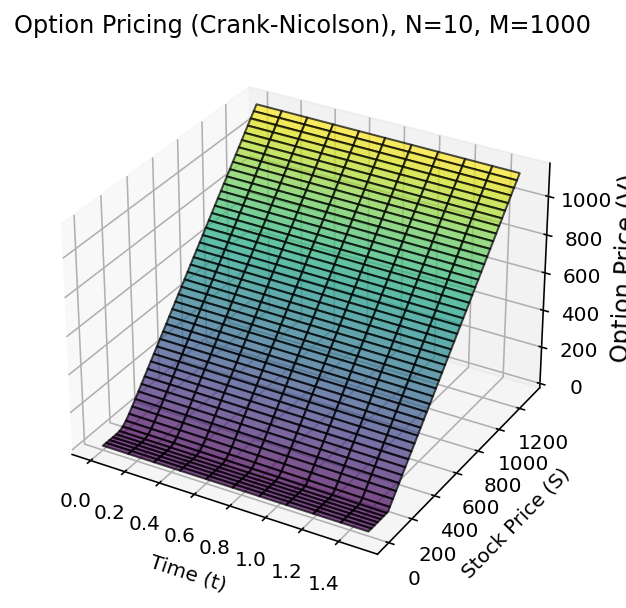

In [8]:
V, t, S = price_call_crank_nicolson(K=167, T=1.5, r=0.03, gamma=0.98, sigma_func=sigma_t, N=10, M=1000)

def plot_option_price(V, t, S):

    M = len(S) - 1
    S_ = S[0:M]
    V_ = V[:, 0:M] 
    
    t_mesh, S_mesh = np.meshgrid(t, S_)
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(t_mesh, S_mesh, V_.T, alpha=0.7, edgecolor='k', cmap='viridis')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Stock Price (S)')
    ax.set_zlabel('Option Price (V)', fontsize=12)
    ax.set_title('Option Pricing (Crank-Nicolson), N=10, M=1000')

    plt.show()

plot_option_price(V, t, S)

Initial Convergence Investigation


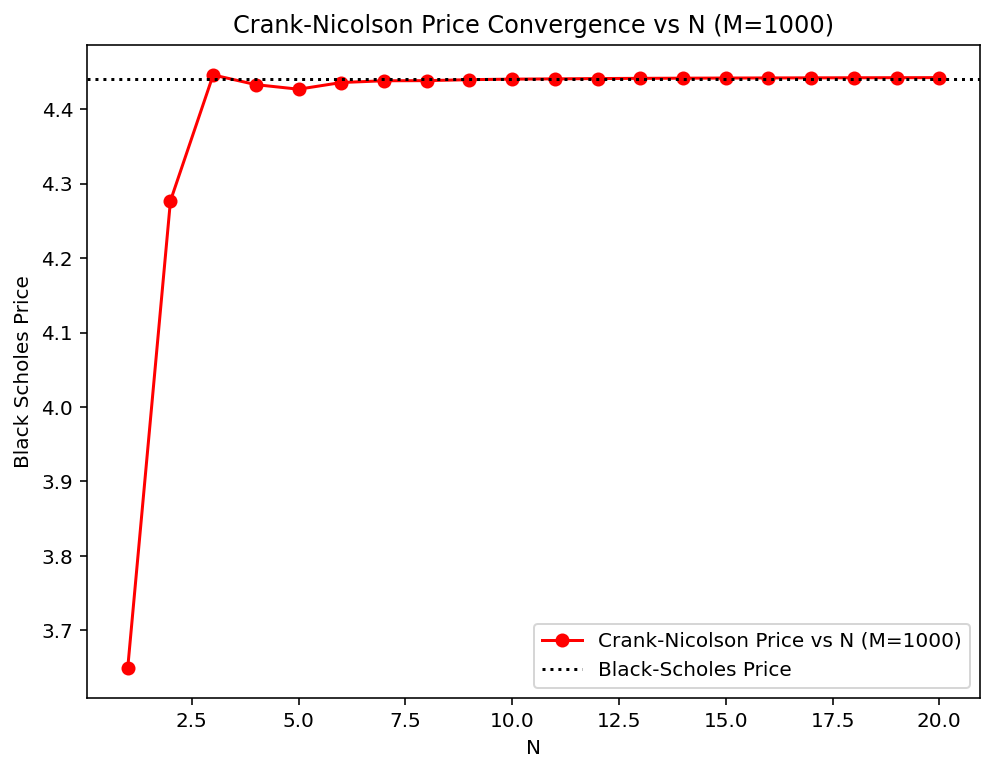

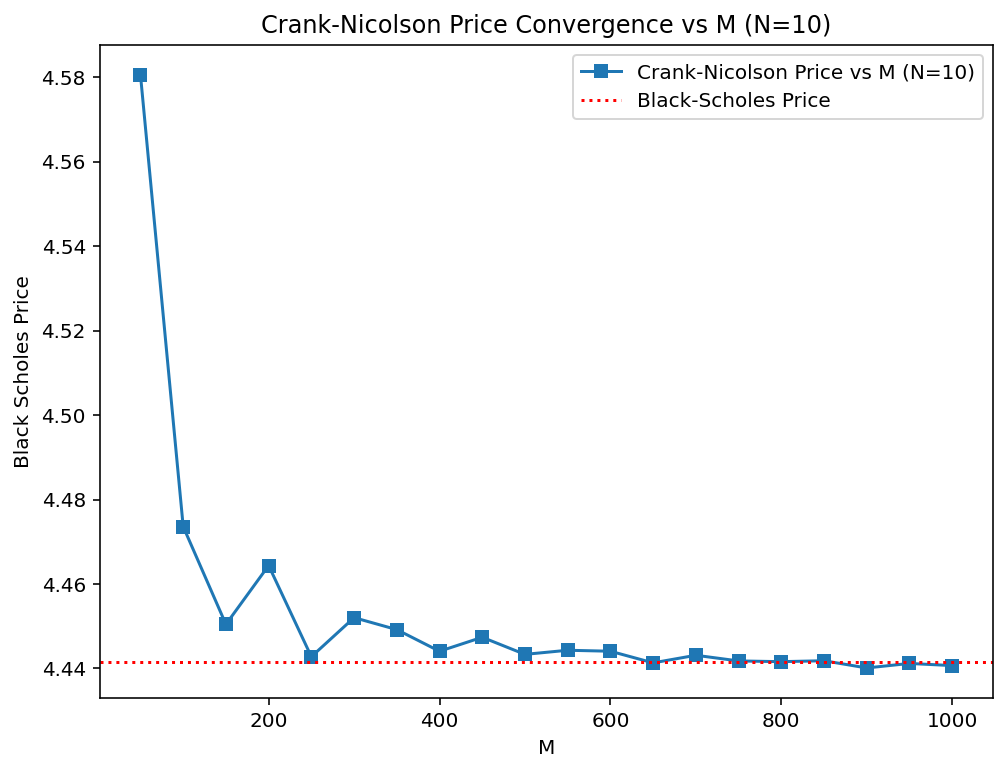

In [9]:
N_values = np.arange(1, 21, 1)
M_values = np.arange(50, 1050, 50)

prices_N = [price_evaluator_crank_nicolson(K, T, r, 1, N, 1000, S0, sigma_func=sigma_constant) for N in N_values]
prices_M = [price_evaluator_crank_nicolson(K, T, r, 1, 10, M, S0, sigma_func=sigma_constant) for M in M_values]

plt.figure(figsize=(8, 6))
plt.plot(N_values, prices_N, 'o-',color = 'red', label='Crank-Nicolson Price vs N (M=1000)')
plt.axhline(y=bs_price, color='black', linestyle='dotted', label='Black-Scholes Price')
plt.xlabel("N")
plt.ylabel("Black Scholes Price")
plt.legend()
plt.title("Crank-Nicolson Price Convergence vs N (M=1000)")
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(M_values, prices_M, 's-', label='Crank-Nicolson Price vs M (N=10)')
plt.axhline(y=bs_price, color='r', linestyle='dotted', label='Black-Scholes Price')
plt.xlabel("M")
plt.ylabel("Black Scholes Price")
plt.legend()
plt.title("Crank-Nicolson Price Convergence vs M (N=10)")
plt.show()

Plotting the Log Log Plot


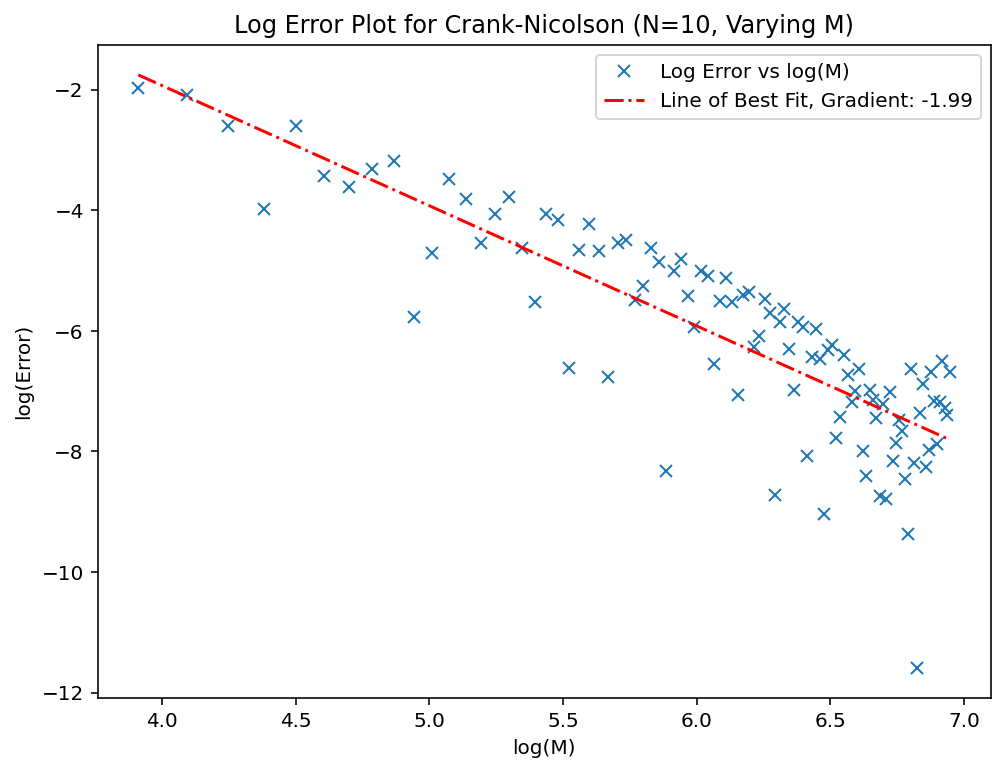

In [10]:
M_values = np.arange(50, 1050, 10)

errors = []

for M in M_values:
    approx = price_evaluator_crank_nicolson(K=167, T=1.5, r=0.03, gamma=1, 
                                            N=10, M=M, S0=130, sigma_func=sigma_constant)
    error = abs(approx - bs_price)
    errors.append(error)

log_M = np.log(M_values)
log_errors = np.log(errors)

gradient, intercept = np.polyfit(log_M, log_errors, 1)
best_fit_line = gradient * log_M + intercept

plt.figure(figsize=(8, 6))
plt.plot(log_M, log_errors, 'x', label='Log Error vs log(M)')
plt.plot(log_M, best_fit_line, '-.', color='red', label=f'Line of Best Fit, Gradient: {gradient:.2f}')
plt.xlabel("log(M)")
plt.ylabel("log(Error)")
plt.title("Log Error Plot for Crank-Nicolson (N=10, Varying M)")
plt.legend()
plt.show()

Monte Carlo


In [11]:
def call_payoff(S,K):
    return np.maximum(S-K,0)

n_paths = 10000
n_steps = 100
p = 0.95


Pricing Function


In [12]:
def simulate_euler_maruyama(S0,r,gamma,T,n_steps,n_paths, sigma_func):
    np.random.seed(112)
    sigma = sigma_func(T, n_steps)
    X = np.zeros([n_paths,n_steps + 1])
    dt = T / n_steps
    X[:,0] = np.log(S0)
    epsilon = np.random.randn(n_paths,n_steps)
    for i in range(n_steps):
        sigma_i = sigma[i]
        drift = (r - 0.5*(sigma_i**2)*(np.exp(X[:,i]*(2*gamma-2))))
        diffusion = sigma_i*np.exp(X[:,i]*(gamma-1))
        X[:,i+1] = X[:,i] + drift*dt + diffusion*np.sqrt(dt)*epsilon[:,i]
    S = np.exp(X)
    return S

def monte_carlo_price(S0,K,r,gamma,T,n_steps,n_paths,p,sigma_func):
    alpha = scipy.stats.norm.ppf((1 - p/100) / 2)
    S = simulate_euler_maruyama(S0,r,gamma,T,n_steps,n_paths,sigma_func)
    S_T = S[:,-1]
    payoff = call_payoff(S_T,K)
    average_payoff = np.mean(payoff)
    price = np.exp(-r*T) * average_payoff
    std_error = np.std(payoff) * np.exp(-r*T)
    lower = price + alpha * std_error / np.sqrt(n_paths)
    upper = price - alpha * std_error / np.sqrt(n_paths)
    error = std_error / np.sqrt(n_paths)
    return price, lower, upper , error

monte_carlo_price(S0,K,r,gamma,T,n_steps,n_paths,p,sigma_func = sigma_t)

(2.935162429460133, 2.9339554006979145, 2.936369458222351, 0.10137335351595114)

Computing the Delta \(Monte Carlo\)


In [13]:
def delta_by_CDT(S0, r, gamma, T, n_steps, n_paths, K, sigma_func):
    dS = S0*10**(-5)  
    
    S_forward = simulate_euler_maruyama(S0 + dS, r, gamma, T, n_steps, n_paths, sigma_func)
    S_T_forward = S_forward[:, -1]
    payoff_forward = call_payoff(S_T_forward, K)
    price_forward = np.exp(-r*T)*np.mean(payoff_forward)
    
    S_back = simulate_euler_maruyama(S0 - dS, r, gamma, T, n_steps, n_paths, sigma_func)
    S_T_back = S_back[:, -1]
    payoff_back = call_payoff(S_T_back, K)
    price_back = np.exp(-r*T)*np.mean(payoff_back)
    
    delta = (price_forward - price_back) / (2 * dS)
    return delta


def compute_delta_montecarlo_confidence_interval(S0,K,r,gamma,T,n_steps,n_paths,p, sigma_func):
    dS = S0*10**(-5)
    S_forward = simulate_euler_maruyama(S0+dS,r,gamma,T,n_steps,n_paths,sigma_func)
    S_T_forward = S_forward[:,-1]
    payoff_forward = call_payoff(S_T_forward,K)
    S_back = simulate_euler_maruyama(S0 - dS, r, 1, T, n_steps, n_paths, sigma_func)
    S_T_back = S_back[:, -1]
    payoff_back = call_payoff(S_T_back, K)
    payoff_diff = payoff_forward - payoff_back
    std_delta = (np.exp(-r*T) / (2*n_paths*dS)) * np.std(payoff_diff)
    delta = delta_by_CDT(S0, r, gamma, T, n_steps, n_paths, K, sigma_func)
    
    alpha = scipy.stats.norm.ppf((1 - p/100)/2)
    lower = delta + alpha*std_delta / np.sqrt(n_paths)
    upper = delta - alpha*std_delta / np.sqrt(n_paths)
    return lower, upper, delta

compute_delta_montecarlo_confidence_interval(S0,K,r,gamma,T,n_steps,n_paths,p,sigma_func=sigma_t)

(0.199173248038726, 0.1991947052603012, 0.1991839766495136)

Stock Paths Plot & QQ Plot


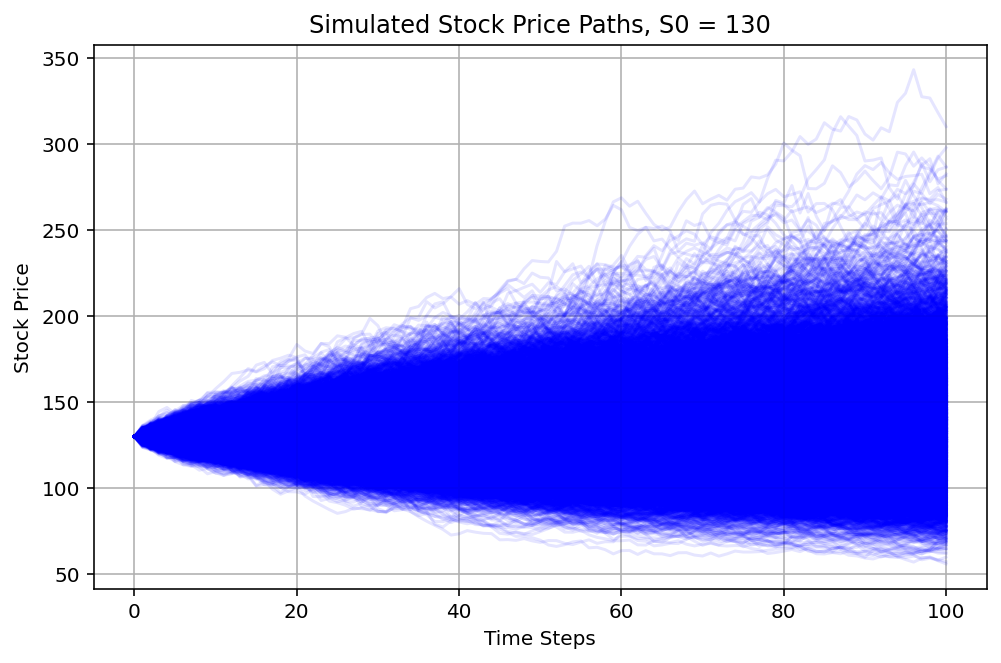

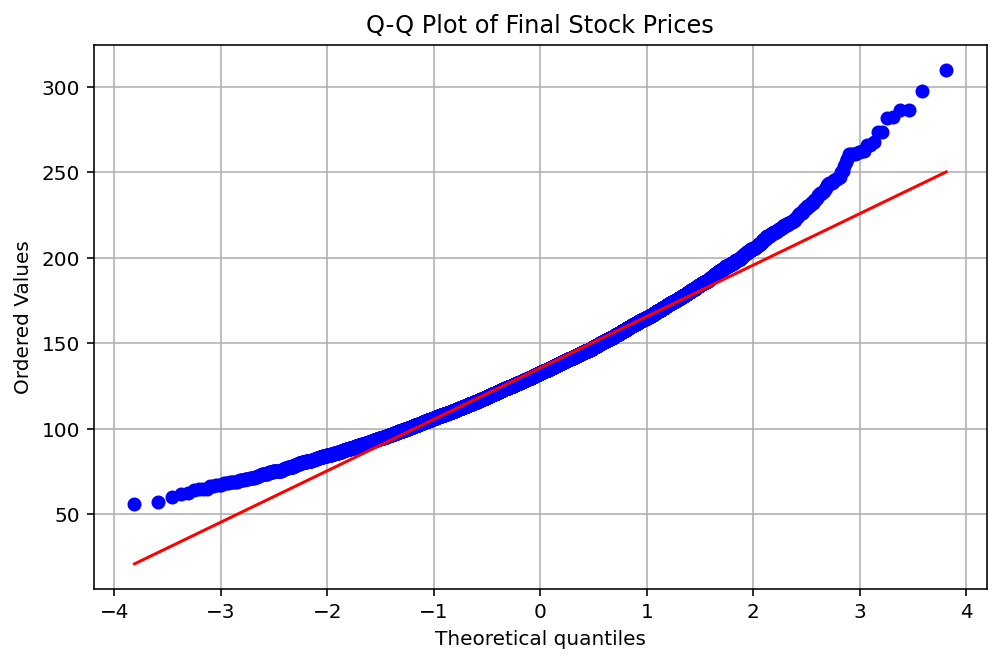

In [14]:
stock_paths = simulate_euler_maruyama(S0,0.03,0.98,1.5,100,10000,sigma_func = sigma_t)
plt.figure(figsize=(8, 5))
plt.plot(stock_paths.T, color='blue', alpha=0.1)
plt.title('Simulated Stock Price Paths, S0 = 130')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

S_T = stock_paths[:,-1]

plt.figure(figsize=(8, 5))
scipy.stats.probplot(S_T, dist="norm", plot=plt)
plt.title('Q-Q Plot of Final Stock Prices')
plt.grid(True)
plt.show()

Monte Carlo Convergence Investigation


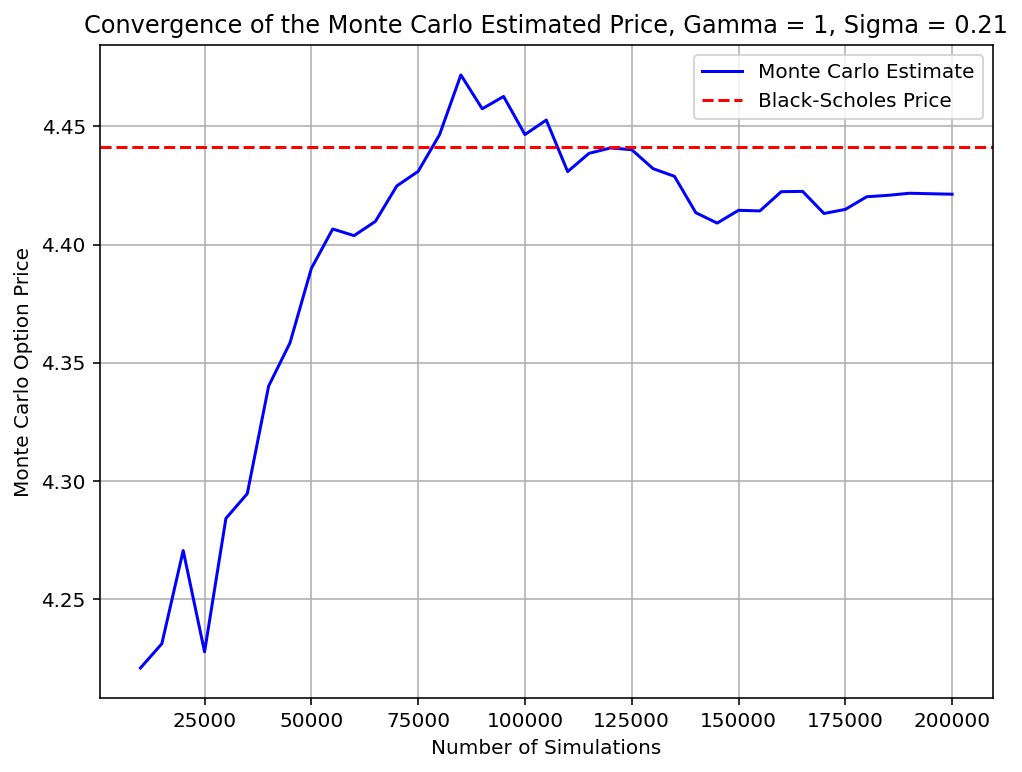

In [15]:

simulations = np.arange(10000, 200001, 5000)
monte_carlo_prices = []
errors = []


for n_paths in simulations:
    price, lower, upper, error = monte_carlo_price(S0, K, r, 1, T, n_steps, n_paths, p, sigma_constant)
    monte_carlo_prices.append(price)
    
    errors.append(error)

plt.figure(figsize=(8, 6))
plt.plot(simulations, monte_carlo_prices, label='Monte Carlo Estimate', color='blue')
plt.axhline(y=black_scholes_call_price(S0, 0,K,T,r,0.21), color='red', linestyle='--', label='Black-Scholes Price')
plt.title('Convergence of the Monte Carlo Estimated Price, Gamma = 1, Sigma = 0.21')
plt.xlabel('Number of Simulations')
plt.ylabel('Monte Carlo Option Price')
plt.legend()
plt.grid(True)
plt.show()

Log Log Convergence Plot Generation


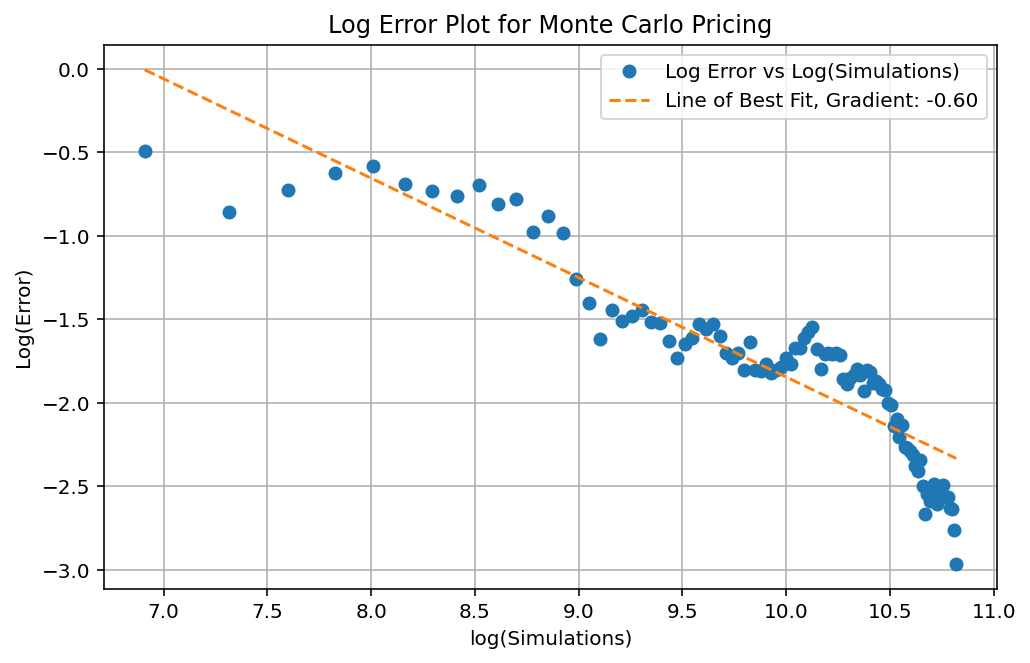

In [16]:

bs_price = black_scholes_call_price(130, 0, 167, 1.5, 0.03, 0.21)

simulations = np.arange(1000, 50001, 500)

errors = []

for n_paths in simulations:
    mc_price, _, _, mc_error = monte_carlo_price(130, 167, 0.03, 1, 1.5, 100, n_paths, 0.95, sigma_func=sigma_constant)
    error = abs(mc_price - bs_price)
    errors.append(error)

log_n_paths = np.log(simulations)
log_errors = np.log(errors)

plt.figure(figsize=(8, 5))
plt.plot(log_n_paths, log_errors, 'o', label='Log Error vs Log(Simulations)')
plt.xlabel("log(Simulations)")
plt.ylabel("Log(Error)")
plt.title("Log Error Plot for Monte Carlo Pricing")
plt.legend()
plt.grid(True)


gradient, intercept = np.polyfit(log_n_paths, log_errors, 1)
plt.plot(log_n_paths, gradient * log_n_paths + intercept, '--', label=f'Line of Best Fit, Gradient: {gradient:.2f}')

plt.legend()
plt.show()


Monte Carlo Tests, when simulations = 10\*\*5, Gamma = 1


In [17]:
def test_price_by_monte_carlo():
    p = 0.95
    S0 = 130
    r = 0.03
    T = 1.5
    n_steps = 100
    K = 167
    
    sigma = sigma_constant(T,n_steps)[0]
    sigma_func = sigma_constant
    
    price, low, high, error = monte_carlo_price(S0, K, 1, T, n_steps, 10**5, K, p, sigma_func=sigma_constant)
    bs_price = black_scholes_call_price(S0, 0, K, T, r, sigma)
    
    assert np.abs(low - bs_price) < 0.1
    assert np.abs(high - bs_price) < 0.1
    assert np.abs(bs_price - monte_carlo_price) < 0.1 

def test_delta_by_monte_carlo():
    p = 0.95
    S0 = 130
    r = 0.03
    T = 1.5
    n_steps = 100
    K = 167
    sigma = sigma_constant(T,n_steps)[0]
    sigma_func = sigma_constant
    
    low, high, mc_delta = compute_delta_montecarlo_confidence_interval(S0,K,r,1,T,n_steps,10**5,p, sigma_func=sigma_constant)
    bs_delta = black_scholes_delta(S0,0,K,T,r,sigma)
    
    assert np.abs(low - bs_delta) < 0.01
    assert np.abs(high - bs_delta) < 0.01
    assert np.abs(bs_delta - mc_delta) < 0.01

Finite Difference Methods Tests, N = 10, M = 1000, Gamma = 1


In [18]:
def test_crank_nicolson_price():
    S0 = 130
    r = 0.03
    N = 10
    M = 1000
    T = 1.5
    n_steps = 100
    K = 167
    sigma = sigma_constant(T,n_steps)[0]
    sigma_func = sigma_constant
    
    price_cn = price_evaluator_crank_nicolson(K,T,r,1,N,M,S0, sigma_func=sigma_constant)
    bs_price = black_scholes_call_price(S0,0,K,T,r,sigma)
    
    assert np.abs(price_cn - bs_price) < 0.01

def test_crank_nicolson_delta():
    S0 = 130
    r = 0.03
    N = 10
    M = 1000
    T = 1.5
    n_steps = 100
    K = 167
    sigma = sigma_constant(T,n_steps)[0]
    sigma_func = sigma_constant
    
    bs_delta = black_scholes_delta(S0,0,K,T,r,sigma)
    cn_delta = delta_with_crank_nicolson(K,T,r,1,10,1000,S0,sigma_func=sigma_constant)
    assert np.abs(cn_delta - bs_delta) < 0.01